In [22]:
# Core TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Numerical and data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# File handling
import os
import glob

In [2]:
print(os.getcwd())

C:\Users\user\anaconda3\envs\mlp\Image classification problems


In [3]:
dataset_path = r'C:\Users\user\anaconda3\envs\mlp\Image classification problems\train'
classes = os.listdir(dataset_path)
print("Number of classes:", len(classes))
print("Class names:", classes[:10])  # Show first 5
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(dataset_path, cls)))} images")

Number of classes: 100
Class names: ['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ARCIGERA FLOWER MOTH', 'ATALA', 'ATLAS MOTH', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK']
ADONIS: 126 images
AFRICAN GIANT SWALLOWTAIL: 107 images
AMERICAN SNOOT: 105 images
AN 88: 121 images
APPOLLO: 128 images
ARCIGERA FLOWER MOTH: 140 images
ATALA: 143 images
ATLAS MOTH: 129 images
BANDED ORANGE HELICONIAN: 139 images
BANDED PEACOCK: 118 images
BANDED TIGER MOTH: 136 images
BECKERS WHITE: 116 images
BIRD CHERRY ERMINE MOTH: 133 images
BLACK HAIRSTREAK: 121 images
BLUE MORPHO: 107 images
BLUE SPOTTED CROW: 123 images
BROOKES BIRDWING: 165 images
BROWN ARGUS: 169 images
BROWN SIPROETA: 140 images
CABBAGE WHITE: 127 images
CAIRNS BIRDWING: 117 images
CHALK HILL BLUE: 149 images
CHECQUERED SKIPPER: 136 images
CHESTNUT: 122 images
CINNABAR MOTH: 131 images
CLEARWING MOTH: 122 images
CLEOPATRA: 133 images
CLODIUS PARNASSIAN: 122 images
CLOUDED SULPHUR: 128 images
COMET MOTH

In [10]:
base_path = r'C:\Users\user\anaconda3\envs\mlp\Image classification problems'
    # Create data generators
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
valid_datagen = ImageDataGenerator(rescale=1./255)

    # Load training data
train_generator = train_datagen.flow_from_directory(
        os.path.join(base_path, 'train'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )

    # Load validation data
valid_generator = valid_datagen.flow_from_directory(
        os.path.join(base_path, 'valid'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    # Load test data
test_generator = valid_datagen.flow_from_directory(
        os.path.join(base_path, 'test'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    # Get number of classes
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)
print("Class names:", list(train_generator.class_indices.keys())[:5])

Found 12594 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Number of classes: 100
Class names: ['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO']


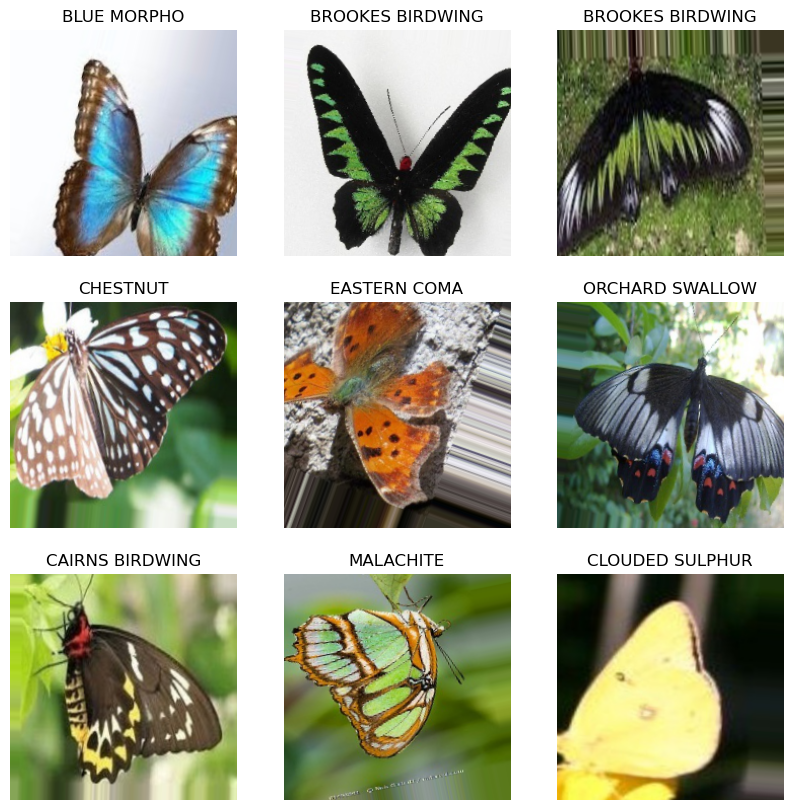

In [12]:
images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(list(train_generator.class_indices.keys())[np.argmax(labels[i])])
    plt.axis('off')
plt.show()

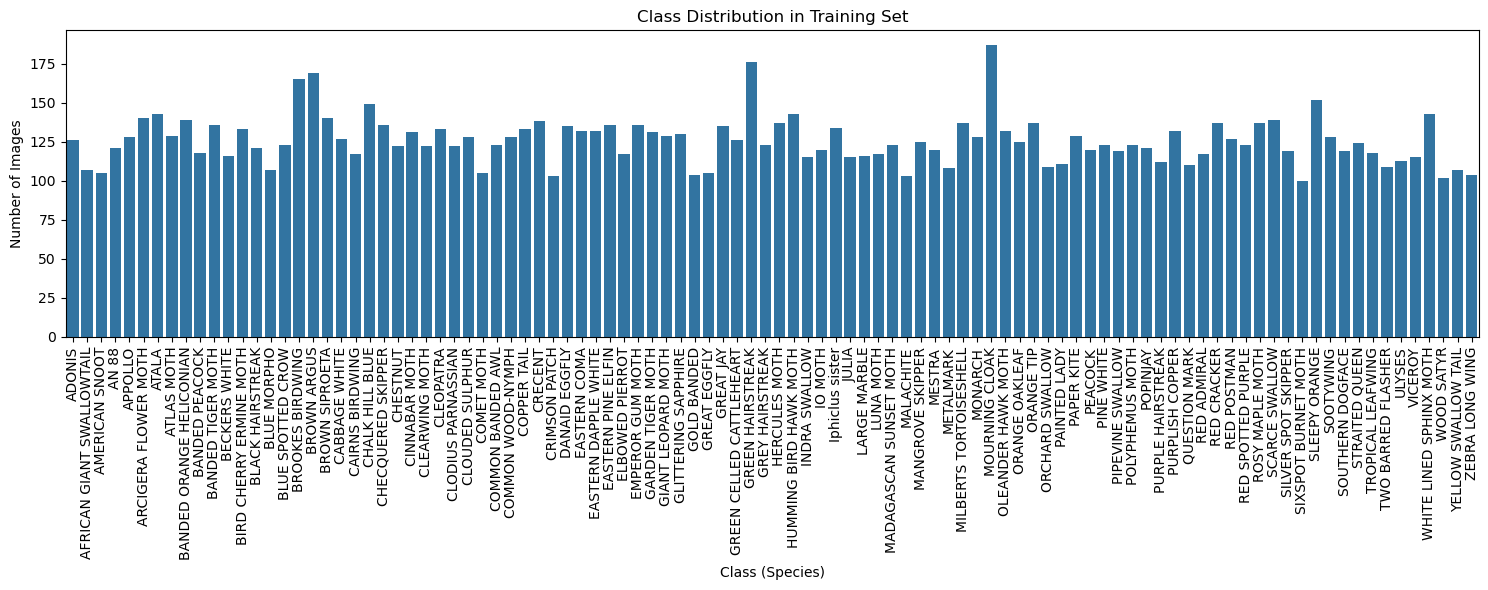

In [18]:
train_dir = dataset_path
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, cls))}
plt.figure(figsize=(15, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class (Species)")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

In [24]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

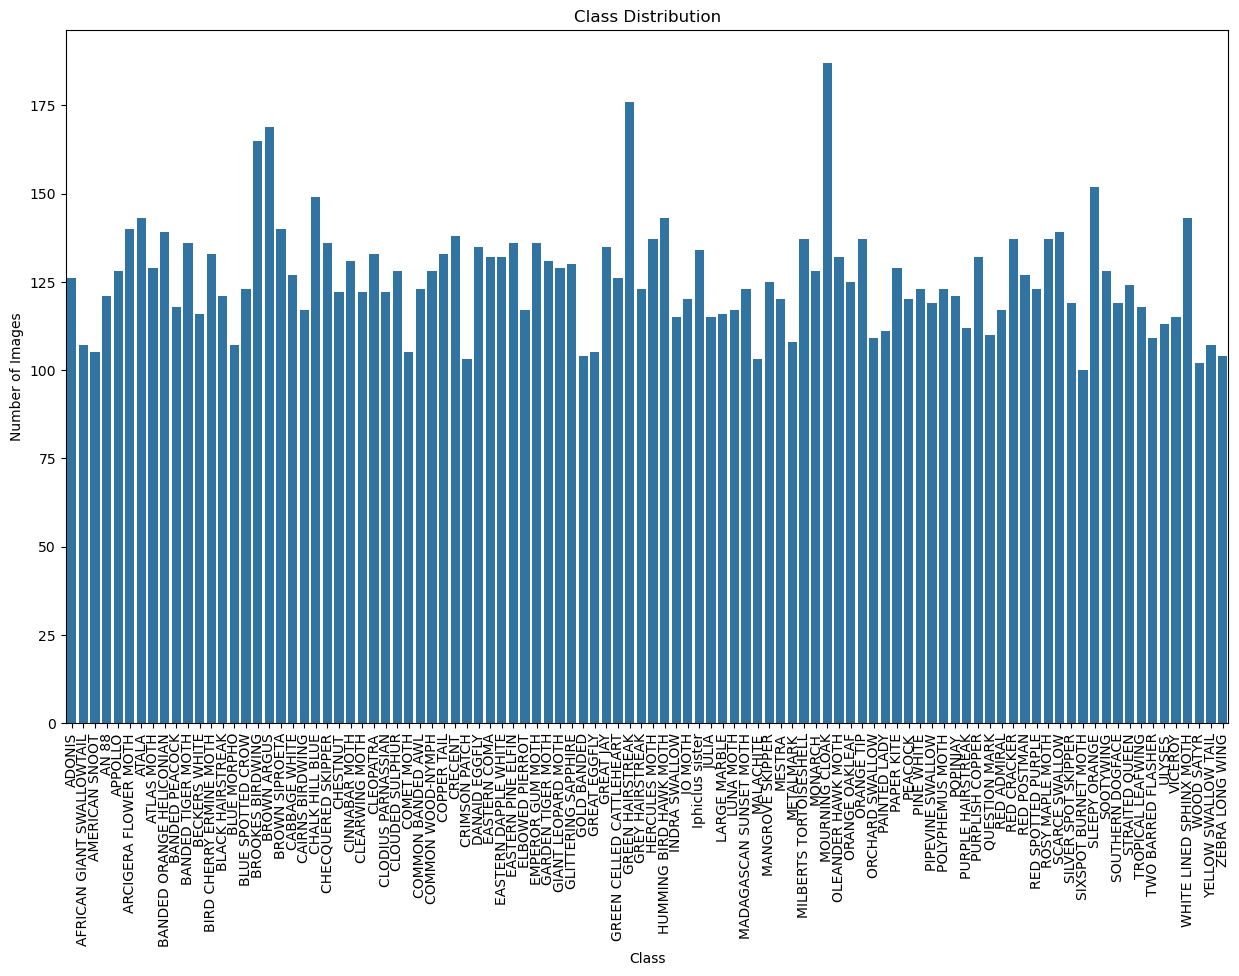

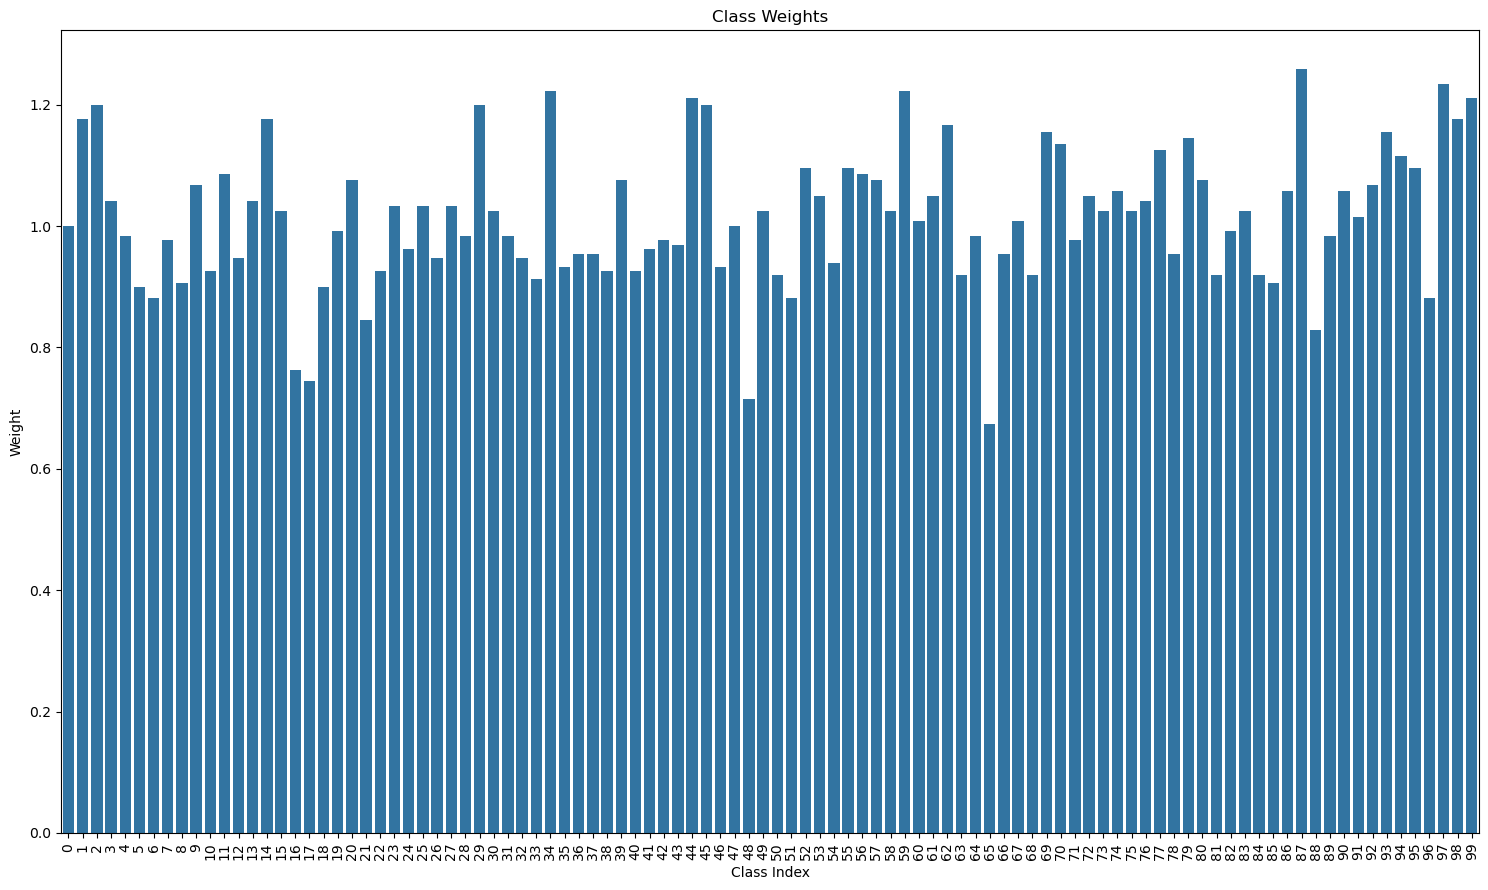

In [28]:
plt.figure(figsize= (15, 9))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")

plt.figure(figsize = (15, 9))
sns.barplot(x=[str(k) for k in class_weights.keys()], y=list(class_weights.values()))
plt.xticks(rotation=90)
plt.title("Class Weights")
plt.xlabel("Class Index")
plt.ylabel("Weight")
plt.tight_layout()
plt.show()

In [30]:
# Step 1: Define the base model (MobileNetV2)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Step 2: Freeze the base model
base_model.trainable = False

# Step 3: Build the custom model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(100, activation='softmax')
])

# Step 4: Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 5: Display the model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 19s 2us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,965,156 (11.31 MB)

 Trainable params: 707,172 (2.70 MB)

 Non-trainable params: 2,257,984 (8.61 MB)